# Team 01 - 岳叔在隊不用準備
106024518 張家豪
105024701 李漢岳
106024521 黃信恩


In [1]:
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import skimage
import pickle as pkl
import tensorflow.python.platform
from collections import Counter
import _pickle as cPickle
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

## Data processing

對資料中的原標語做以下的處理：
1. 在每個標語的前後加上 < ST > 和 < ED >
2. 用連續的整數IDs代表一句標語
3. 為了保留最大訊息，將使用全部的單字

再藉由字典，可將每一句標語的連續整數IDs還原成原句，得到的處理後的三個資料集為：
1. train_enc_cap.csv：包含training data中影像名稱ID和標語轉成IDs的dataframe
2. enc_map.pkl：將單字對應到ID的字典(map token => id)
3. dec_map.pkl：將ID對應回單字的字典(map id => token)

讀入以上三個資料集：

In [2]:
df_cap = pd.read_csv('train_enc_cap.csv')  # a dataframe - 'img_id', 'cpation'
enc_map = cPickle.load(open('enc_map.pkl', 'rb'))  # token => id
dec_map = cPickle.load(open('dec_map.pkl', 'rb'))  # id => token
vocab_size = len(dec_map)

原始資料集過大，這裡使用VGG-16的pre-trained CNN model所提供的特徵值，並利用PCA將倒數第二層的output降維到256維，即以下的資料檔：train_img256，training的影像數共102739個

In [3]:
img_train = cPickle.load(open('train_img256.pkl', 'rb'))
# transform img_dict to dataframe
img_train_df = pd.DataFrame(list(img_train.items()), columns=['img_id', 'img'])
print('Images for training: {}'.format(img_train_df.shape[0]))

Images for training: 102739


##  利用 img_id 將圖片壓縮過後的256 dim 向量和對應的caption對齊
##  整理成兩個檔案 feats cap

In [4]:
#feats=[]
#cap=[]
#for idx, row in img_train_df.iterrows():
#
#    img_representation = row['img']  # img representation in 256-d array format
#
#      # each image has some captions describing it.
#    for _, inner_row in df_cap[df_cap['img_id'] == row['img_id']].iterrows():
#        caption = eval(inner_row[
#            'caption'])  # caption in different sequence length list format
#
#        # construct 'example' object containing 'img', 'caption'
#        feats.append(img_representation)
#        cap.append(caption)
#np.save('feats.npy',feats)
#np.save('cap.npy',cap)

In [5]:
feats=np.load('feats.npy')
cap=np.load('cap.npy')

In [6]:
cap_new=[]
for j in cap:
    cap_new.append( ' '.join ([dec_map[i]  for i in j]) )

In [7]:
cap_new = np.array(cap_new, dtype=object)

In [8]:
cap_new[:3]

array(['<ST> cellphones whine forward oatmeal baseball level cellphones radio incoming <ED>',
       '<ST> cellphones whine star cabbage menu lambs cellphones pans engines <ED>',
       '<ST> viewed every consists star forward plenty engines shell cellphones pans <ED>'],
      dtype=object)

In [9]:
model_path = 'models/tensorflow'
model_path_transfer = 'models/tf_final'

### 建立字典

In [10]:
def preProBuildWordVocab(sentence_iterator, word_count_threshold=30): # function from Andre Karpathy's NeuralTalk
    print('preprocessing %d word vocab' % (word_count_threshold, ))
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
        nsents += 1
        for w in sent.lower().split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

    ixtoword = {}
    ixtoword[0] = '<END>'
    wordtoix = {}
    wordtoix['<END>'] = 0 
    ix = 1
    for w in vocab:
        wordtoix[w] = ix
        ixtoword[ix] = w
        ix += 1

    word_counts['<END>'] = nsents
    bias_init_vector = np.array([1.0*word_counts[ixtoword[i]] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) 
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) 
    return wordtoix, ixtoword, bias_init_vector.astype(np.float32)

### 模型建立

- 利用RNN及LSTM網絡，來訓練在給定已有前面單詞的情況下網絡預測後續一系列描述圖像的句子的功能。LSTM的輸出是由該模型基於原有的單詞序列為下一個單詞生成的概率分佈。該模型的訓練目標是為了最大化每個單詞對數概率的總和指標，這邊使用的優化函數是AdamOptimizer。
- 訓練後，得到模型，能夠根據圖像和標題的已有單詞給出下一個單詞出現的概率。接著我們根據輸入圖像並迭代輸出下一個最可能的單詞，來構建單個標題。

In [11]:
class Caption_Generator():
    def __init__(self, dim_in, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, init_b=None):

        self.dim_in = dim_in
        self.dim_embed = dim_embed
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.n_lstm_steps = n_lstm_steps
        self.n_words = n_words
        
        # declare the variables to be used for our word embeddings
        with tf.device("/cpu:0"):
            self.word_embedding = tf.Variable(tf.random_uniform([self.n_words, self.dim_embed], -0.1, 0.1), name='word_embedding')

        self.embedding_bias = tf.Variable(tf.zeros([dim_embed]), name='embedding_bias')
        
        # declare the LSTM itself
        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden)
        
        # declare the variables to be used to embed the image feature embedding to the word embedding space
        self.img_embedding = tf.Variable(tf.random_uniform([dim_in, dim_hidden], -0.1, 0.1), name='img_embedding')
        self.img_embedding_bias = tf.Variable(tf.zeros([dim_hidden]), name='img_embedding_bias')

        # declare the variables to go from an LSTM output to a word encoding output
        self.word_encoding = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='word_encoding')
        
        # optional initialization setter for encoding bias variable 
        if init_b is not None:
            self.word_encoding_bias = tf.Variable(init_b, name='word_encoding_bias')
        else:
            self.word_encoding_bias = tf.Variable(tf.zeros([n_words]), name='word_encoding_bias')

    def build_model(self):
        # declaring the placeholders for our extracted image feature vectors, our caption, and our mask
        # (describes how long our caption is with an array of 0/1 values of length `maxlen`  
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        caption_placeholder = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])
        
        # getting an initial LSTM embedding from our image_imbedding
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        
        # setting initial state of our LSTM
        state = self.lstm.zero_state(self.batch_size, dtype=tf.float32)

        total_loss = 0.0
        with tf.variable_scope("RNN"):
            for i in range(self.n_lstm_steps): 
                if i > 0:
                   #if this isn’t the first iteration of our LSTM we need to get the word_embedding corresponding
                   # to the (i-1)th word in our caption 
                    with tf.device("/cpu:0"):
                        current_embedding = tf.nn.embedding_lookup(self.word_embedding, caption_placeholder[:,i-1]) + self.embedding_bias
                else:
                     #if this is the first iteration of our LSTM we utilize the embedded image as our input 
                    current_embedding = image_embedding
                if i > 0: 
                    # allows us to reuse the LSTM tensor variable on each iteration
                    tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(current_embedding, state)

                
                if i > 0:
                    #get the one-hot representation of the next word in our caption 
                    labels = tf.expand_dims(caption_placeholder[:, i], 1)
                    ix_range=tf.range(0, self.batch_size, 1)
                    ixs = tf.expand_dims(ix_range, 1)
                    concat = tf.concat([ixs, labels],1)
                    onehot = tf.sparse_to_dense(
                            concat, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0)


                    #perform a softmax classification to generate the next word in the caption
                    logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=onehot)
                    xentropy = xentropy * mask[:,i]

                    loss = tf.reduce_sum(xentropy)
                    total_loss += loss

            total_loss = total_loss / tf.reduce_sum(mask[:,1:])
            return total_loss, img,  caption_placeholder, mask


    def build_generator(self, maxlen, batchsize=1):
        #same setup as `build_model` function 
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        state = self.lstm.zero_state(batchsize,dtype=tf.float32)

        #declare list to hold the words of our generated captions
        all_words = []
        with tf.variable_scope("RNN"):
            # in the first iteration we have no previous word, so we directly pass in the image embedding
            # and set the `previous_word` to the embedding of the start token ([0]) for the future iterations
            output, state = self.lstm(image_embedding, state)
            previous_word = tf.nn.embedding_lookup(self.word_embedding, [0]) + self.embedding_bias

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()
                out, state = self.lstm(previous_word, state)
                # get a one-hot word encoding from the output of the LSTM
                logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                best_word = tf.argmax(logit, 1)

                with tf.device("/cpu:0"):
                    # get the embedding of the best_word to use as input to the next iteration of our LSTM 
                    previous_word = tf.nn.embedding_lookup(self.word_embedding, best_word)

                previous_word += self.embedding_bias

                all_words.append(best_word)

        return img, all_words

### 訓練模型

- training RNN時，我們使用了gradient-clipping，即若梯度的norm大於某個给定值，就讓他維持在這個上限，這樣可以避免遇到gradient explosion的問題。

In [13]:
def train(feats,captions,learning_rate=0.01, continue_training=False, transfer=True):
    
    tf.reset_default_graph()
    wordtoix, ixtoword, init_b = preProBuildWordVocab(captions)
    np.save('data/ixtoword', ixtoword)

    index = (np.arange(len(feats)).astype(int))
    np.random.shuffle(index)

    sess = tf.InteractiveSession()
    n_words = len(wordtoix)
    maxlen = np.max( [x for x in map(lambda x: len(x.split(' ')), captions) ] )
    caption_generator = Caption_Generator(dim_in, dim_hidden, dim_embed, batch_size, maxlen+2, n_words, init_b)

    loss, image, sentence, mask = caption_generator.build_model()

    saver = tf.train.Saver(max_to_keep=100)
    global_step=tf.Variable(0,trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate, global_step,int(len(index)/batch_size), 0.95)
    train_op = tf.train.AdamOptimizer(learning_rate)
    grads_and_vars = train_op.compute_gradients(loss,tf.trainable_variables())
    clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], 1.0), gv[1]) for gv in grads_and_vars]
    train_op = train_op.apply_gradients(clipped_grads_and_vars, global_step=global_step)
    tf.global_variables_initializer().run()

    if continue_training:
        if not transfer:
            saver.restore(sess,tf.train.latest_checkpoint(model_path))
        else:
            saver.restore(sess,tf.train.latest_checkpoint(model_path_transfer))
    losses=[]
    for epoch in range(n_epochs):
        for start, end in zip( range(0, len(index), batch_size), range(batch_size, len(index), batch_size)):

            current_feats = feats[index[start:end]]
            current_captions = captions[index[start:end]]
            current_caption_ind = [x for x in map(lambda cap: [wordtoix[word] for word in cap.lower().split(' ')[:-1] if word in wordtoix], current_captions)]

            current_caption_matrix =  tf.keras.preprocessing.sequence.pad_sequences(current_caption_ind, padding='post', maxlen=maxlen+1)
            current_caption_matrix = np.hstack( [np.full( (len(current_caption_matrix),1), 0), current_caption_matrix] )

            current_mask_matrix = np.zeros((current_caption_matrix.shape[0], current_caption_matrix.shape[1]))
            nonzeros = np.array([x for x in map(lambda x: (x != 0).sum()+2, current_caption_matrix )])

            for ind, row in enumerate(current_mask_matrix):
                row[:nonzeros[ind]] = 1

            _, loss_value = sess.run([train_op, loss], feed_dict={
                image: current_feats.astype(np.float32),
                sentence : current_caption_matrix.astype(np.int32),
                mask : current_mask_matrix.astype(np.float32)
                })

            print("Current Cost: ", loss_value, "\t Epoch {}/{}".format(epoch, n_epochs), "\t Iter {}/{}".format(start,len(feats)))
        print("Saving the model from epoch: ", epoch)
        saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)

開始訓練模型，並記錄每個epoch下的loss值：

In [ ]:
%%time
dim_embed = 256
dim_hidden = 256
dim_in = 256
batch_size = 256
momentum = 0.9
n_epochs = 1300
train(feats,cap_new,learning_rate=0.0001, continue_training=False, transfer=False)

In [15]:
# continue training
#n_epochs = 500
#train(feats,cap_new,learning_rate=0.0001, continue_training=True, transfer=False)

In [16]:
### Set Hyperparameters ### output
dim_embed = 256
dim_hidden = 256
dim_in = 256
batch_size = 1
learning_rate = 0.0001
momentum = 0.9
n_epochs = 1

In [17]:
if not os.path.exists('data/ixtoword.npy'):
    print ('You must run 1. O\'reilly Training.ipynb first.')
else:
    ixtoword = np.load('data/ixtoword.npy').tolist()
    n_words = len(ixtoword)
    maxlen=15
    
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    caption_generator = Caption_Generator(dim_in, dim_hidden, dim_embed, batch_size, maxlen+2, n_words)

    image, generated_words = caption_generator.build_generator(maxlen=maxlen)

/usr/bin/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 測試模型

載入testing dataset，其如前面training dataset一樣，是使用VGG-16的pre-trained CNN model所提供的特徵值，並利用PCA將倒數第二層的output降維到256維，即以下的資料檔：test_img256

In [18]:
img_test = cPickle.load(open('test_img256.pkl', 'rb'))
img_test_df = pd.DataFrame(list(img_test.items()), columns=['img_id', 'img'])

In [19]:
def test(feats,sess,image,generated_words,ixtoword,idx=0): # Naive greedy search
    img_ids=[]
    caps=[]
    caption_new=[]
    
    feat = np.array(feats)[idx][1]
    feat = np.reshape(feat, (1, 256))
    
    saver = tf.train.Saver()
    sanity_check= False
    #sanity_check=True
    if not sanity_check:
        saved_path=tf.train.latest_checkpoint(model_path)
        saver.restore(sess, saved_path)
    else:
        tf.global_variables_initializer().run()
    for idx in range(20548):
        img_ids.append(feats.iloc[idx,0])
        feat = np.array(feats)[idx][1]
        feat = np.reshape(feat, (1, 256))
        generated_word_index= sess.run(generated_words, feed_dict={image:feat})
        generated_word_index = np.hstack(generated_word_index)

        generated_sentence = [ixtoword[x] for x in generated_word_index]
        caps.append(generated_sentence)
        
    for i  in caps:
    #caption=' '.join(caption)
        caption_new.append(' '.join(i))
    return pd.DataFrame({
      'img_id': img_ids,
      'caption': caption_new
        }).set_index(['img_id'])

開始測試模型，得到每個影像產生出的標語：

In [21]:
df_predict=test(img_test_df,sess,image,generated_words,ixtoword)

In [24]:
df_predict

,img_id,caption
0,134297.jpg,a group of people standing around a ski slope
1,336695.jpg,a motorcycle parked on the side of a road
2,162144.jpg,a man in a red jacket is skiing on a mountain
3,321980.jpg,a dog is sitting on a couch with a laptop
4,397675.jpg,a herd of zebra standing on top of a lush gre...
5,284706.jpg,a toilet in a bathroom with a
6,391895.jpg,a man riding a motorcycle down a dirt road
7,37222.jpg,a man sitting on a bench with a dog in his lap
8,162318.jpg,a bench sitting in the middle of a forest
9,353931.jpg,a traffic light sitting on the side of a road


將產生出的標語檔轉換為以CIDErD為產生標語評量準則的分數：

In [ ]:
os.system("cd CIDErD_linux && gen_score -i demo.csv -r sss.csv")

# Demo

In [27]:
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pre_trained.cnn import PretrainedCNN
import imageio
import skimage.transform
import numpy as np
import scipy

def demo(img_path, cnn_mdl, U, dec_map, hparams, max_len=15):
    """
    displays the caption generated for the image
    -------------------------------
    img_path: image to be captioned
    cnn_mdl: path of the image feature extractor
    U: transform matrix to perform PCA
    dec_map: mapping of vocabulary ID => token string
    hparams: hyperparams for model
    """

    def process_image(img, crop=True, submean=True):
        """
        implements the image preprocess required by VGG-16
        -------------------------------
        resize image to 224 x 224
        crop: do center-crop [skipped by default]
        submean: substracts mean image of ImageNet [skipped by default]
        """
        MEAN = np.array([103.939, 116.779, 123.68]).astype(np.float32) # BGR
        # center crop
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
        img = skimage.transform.resize(crop_img, [224, 224, 3], mode="constant")
        img = img.reshape((224,224,1)) if len(img.shape) < 3 else img
        
        if img.shape[2] < 3:
            print('dimension insufficient')
            img = img.reshape((224*224,
                               img.shape[2])).T.reshape((img.shape[2],
                                                                 224*224))
            for i in range(img.shape[0], 3):
                img = np.vstack([img, img[0,:]])
            img = img.reshape((3,224*224)).T.reshape((224,224,3))
        img = img.astype(np.float32)
        img = img[:,:,::-1]
        # RGB => BGR
        for i in range(3):
            img[:,:,i] -= MEAN[i]
        return img.reshape((224,224,3))

    display(Image(img_path))
    img = imageio.imread(img_path)
    
    # load pretrained cnn model
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        img_feature = np.dot(
            cnn_mdl.get_output(sess, [process_image(img)])[0].reshape((-1)), U)
        
    # reset graph for image caption model
    tf.reset_default_graph()  
    model = ImageCaptionModel(hparams)
    model.build()
    with tf.Session(config=config) as sess:
        saver = tf.train.Saver()
        # restore variables from disk.
        ckpt = tf.train.get_checkpoint_state(hparams.ckpt_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, tf.train.latest_checkpoint(hparams.ckpt_dir))
            caption = model.predict(sess, img_feature, dec_map)
            print(' '.join(caption))
        else:
            print("No checkpoint found.")

In [ ]:
def get_hparams():
    hparams = tf.contrib.training.HParams(
      vocab_size=vocab_size,
      batch_size=64,
      rnn_units=100,
      image_embedding_size=256,
      word_embedding_size=256,
      drop_keep_prob=0.7,
      lr=1e-3,
      training_epochs=1,
      max_caption_len=15,
      ckpt_dir='model_ckpt/')
    return hparams
# get hperparameters
hparams = get_hparams()

### 使用test data 其中一張圖片做為demo (COCO_val2014_000000336695.jpg)

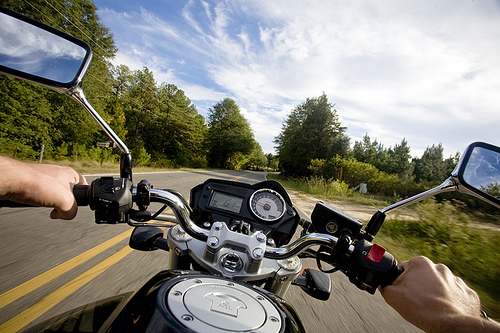

In [31]:
Image("COCO_val2014_000000336695.jpg")

In [32]:
df_predict.caption[1]

' a motorcycle parked on the side of a road '

## Conclusion

這次競賽讓我們學到如何用Tensorflow實作RNN系列模型，在實作上遇到train很久但是minibatch loss降的非常緩慢，往後可以試試其他optimizer函數，像是selu或是RMSProp。原本有使用glove.6b.100d的預訓練詞向量，無奈沒有時間去train到比較好的model就沿用助教給的方法。在test的地方有發現一些與圖片落差很大的句子，也許是與training dataset較不相關的圖片所導致。